In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc, hermite
from matplotlib.colors import hsv_to_rgb
import levlabpython

In [2]:
def angle_kernel(theta, x):
    return np.exp(-np.exp(2j*theta)/4 + np.exp(1j*theta)*x-np.square(x)/2)/np.sqrt(np.pi)

def reverse_angle_kernel(x, theta):
    return np.sqrt(np.pi)*erfc(np.exp(-1j*theta)/2-x)*np.exp(np.square(np.exp(-1j*theta)/2-x)-np.square(x)/2 - 1j*theta)/2

def mahler_kernel(x,y,alpha):
    return np.exp(-(np.square(x)+np.square(y))/(2.*np.tanh(alpha))+x*y/np.sinh(alpha))/np.sqrt(2*np.pi*np.sinh(alpha))

def confocal_projection(x,y,alpha):
    return mahler_kernel(x,y,alpha) + mahler_kernel(x,y,alpha+1j*np.pi/2) + mahler_kernel(x,y,alpha+1j*np.pi) + mahler_kernel(x,y,alpha+3j*np.pi/2)

def hermite_matrix(x):
    N = x.shape[0]
    num = np.arange(N)
    result = np.zeros((N,N))
    for n in range(0,N):
        if n < 15:
            poly = hermite(n)
            result[n] = np.exp(-np.square(x)/2.)*poly(x)
            norm = np.sqrt(np.power(2,n)*np.math.factorial(n)*np.sqrt(np.pi))
            print(norm)
            result[n] = result[n]/norm
        elif n < 100:
            poly = hermite(n)
            result[n] = np.exp(-np.square(x)/2.)*poly(x)
            norm = np.power(np.pi, 0.25)*np.power((2*n)/np.e, n/2.)
            print(norm)
            result[n] = result[n]/norm
        else:
            result[n] = np.sqrt(2)*np.cos(x*np.sqrt(2*n)-n*np.pi/2)*np.power(np.pi*(1-np.square(x)/(2*n+1)),-0.25)
    return result

def gaussian(x,x0, sigma):
    return np.exp(-np.square(x-x0)/(2*np.square(sigma)))/(np.sqrt(2*np.pi)*sigma)

def discrete_angle_transform(vecs):
    N = vecs.shape[0]
    multmatrix = np.einsum("i,j->ij", np.arange(N), np.arange(N))/N
    DFT = np.exp(-2j*np.pi*multmatrix)/np.sqrt(N)
    return DFT @ vecs

def SHO_hamiltonian(x):
    N = x.shape[0]
    dx = x[1]-x[0]
    p2 = (2*np.diag(np.ones(N)) - np.diag(np.ones(N-1),k=1) - np.diag(np.ones(N-1),k=-1))/(dx**2)
    x2 = np.diag(np.square(x))
    return (p2+x2)/2.

def discrete_wigner(dist, L=None):
    N = dist.shape[0]
    if L is None:
        L=N
    W = np.zeros((N,N), dtype=np.complex128)
    for n in range(0,N):
        bound = min(n, N-1-n)
        for m in range(-bound,bound+1):
            W[n,m] += dist[n+m]*np.conj(dist[n-m])*np.exp(-2j*np.pi*m/L)
    return W

In [4]:
def Hcomplex(z):# computes the hue corresponding to the complex number z
    H = np.angle(z) / (2*np.pi) + 1
    return np.mod(H, 1)

def complex2d_plot(field, ax=None):
    if ax is None:
        fig,ax = plt.subplots()
    H = Hcomplex(field)
    HSV = np.dstack((H,np.abs(field),np.ones(field.shape)))
    RGB = hsv_to_rgb(HSV)
    plt.imshow(RGB,origin="lower")

In [19]:
field = np.load("FieldNPYs/shot2.npy")

In [20]:
field.shape

(440, 440)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


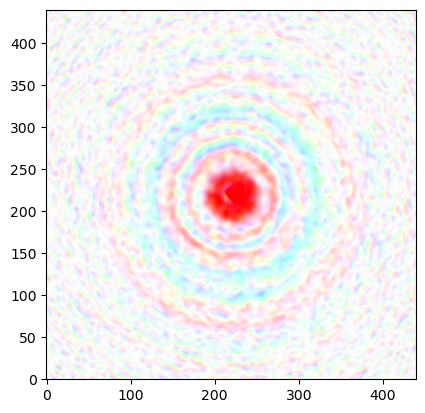

In [21]:
complex2d_plot(field)

In [88]:
x = np.linspace(-4.,4.,100)
theta = np.linspace(0.,np.pi,100)
X,Theta = np.meshgrid(x,theta)
dx = x[1]-x[0]

In [326]:
continous_space_transform = angle_kernel(Theta, X)

In [338]:
np.linalg.matrix_rank(continous_space_transform[350:650])

12

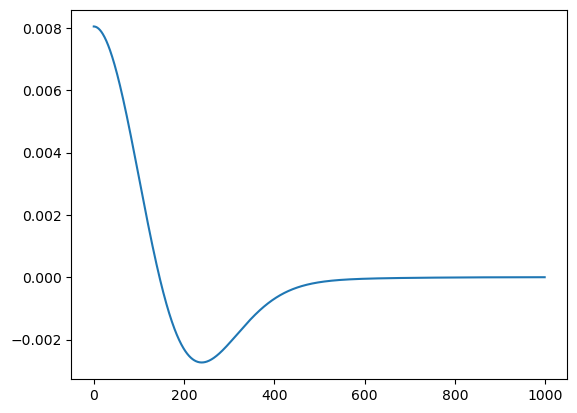

In [343]:
plt.plot(continous_space_transform[:,999])

In [95]:
real_gaussian = gaussian(x,2.0,0.05)
a_cosine = np.cos(5.0*x)*gaussian(x,0.0,1.0)
angle_gaussian = np.einsum("ij,i->j", angle_kernel(Theta,X), real_gaussian)

In [149]:
test1 = np.einsum("i,j->ij", np.exp(1j*theta), x)
test2 = np.einsum("i,j->ij", theta, x)
test3 = np.einsum("i,j->ij", np.arange(1000), np.arange(1000))*2*np.pi/1000
test4 = np.einsum("i,j->ij", np.exp(1j*theta), np.arange(1000)/1000)
f = (np.arange(1000) - 500)/500
test5 = np.einsum("i,j->ij", 2*np.pi*(1j*f - np.sqrt(1-np.square(f))), (np.arange(1000)-500)/1000.)

In [186]:
x = np.linspace(-5.,5.,1000)
y = np.linspace(-5.,5.,1000)
X,Y = np.meshgrid(x,y)
test6 = confocal_projection(X,Y,0.01)

In [203]:
centers = np.linspace(0.,5.,100)
X,Centers = np.meshgrid(x, centers)

In [204]:
gaussian_transform = gaussian(X,Centers, 0.1)

In [205]:
np.linalg.matrix_rank(test6 @ gaussian_transform.T)

89

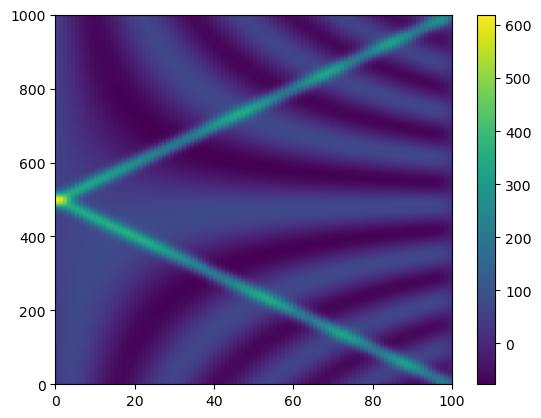

In [206]:
plt.pcolor(np.real(test6 @ gaussian_transform.T))
plt.colorbar()

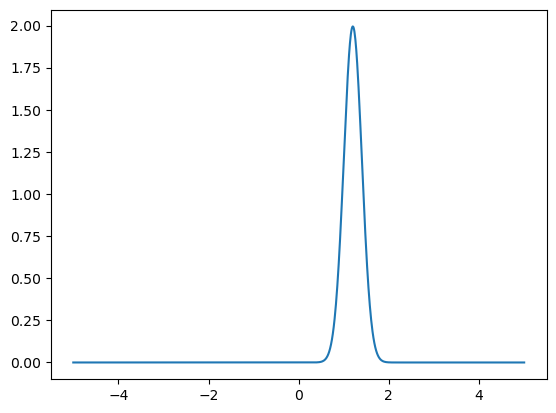

In [228]:
plt.plot(x, np.real(gaussian(x, 1.2,0.2)))

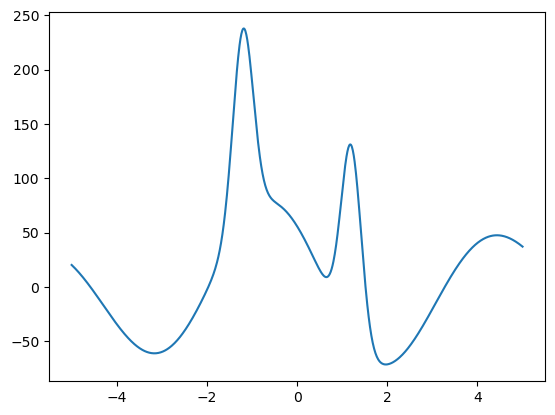

In [229]:
plt.plot(x, np.real(test6 @ gaussian(x, 1.2,0.2)))

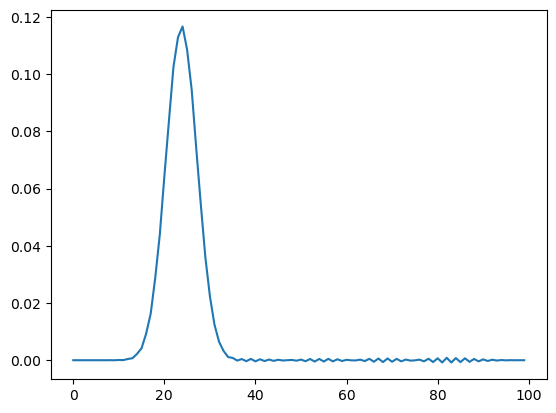

In [230]:
plt.plot(np.real(np.linalg.pinv(test6 @ gaussian_transform.T) @ test6 @ gaussian(x, 1.2,0.2)))

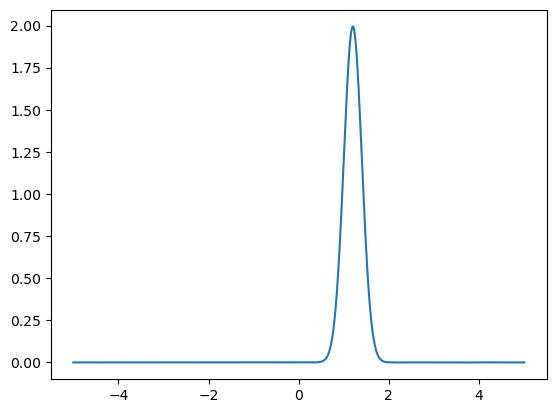

In [231]:
plt.plot(x, np.real(gaussian_transform.T @ np.linalg.pinv(test6 @ gaussian_transform.T) @ test6 @ gaussian(x, 1.2,0.2)))

In [178]:
np.linalg.pinv(test6 @ gaussian_transform.T)

array([[ 0.04360912-0.00166125j,  0.03291039-0.00134309j,
         0.02187803-0.0010361j , ...,  0.00032771+0.02480635j,
         0.00062853+0.03727158j,  0.0009923 +0.04959855j],
       [-0.07112141+0.00235956j, -0.05296104+0.00188789j,
        -0.0343346 +0.00144011j, ..., -0.0004821 -0.03849691j,
        -0.00096042-0.05933341j, -0.00154352-0.08004117j],
       [ 0.08221623-0.00254625j,  0.06028109-0.00201939j,
         0.03793221-0.00152468j, ...,  0.00050509+0.04234561j,
         0.00105418+0.06719176j,  0.00172845+0.09203606j],
       ...,
       [ 0.00172845+0.09203606j,  0.00105418+0.06719176j,
         0.00050509+0.04234561j, ...,  0.03793221-0.00152468j,
         0.06028109-0.00201939j,  0.08221623-0.00254625j],
       [-0.00154352-0.08004117j, -0.00096042-0.05933341j,
        -0.0004821 -0.03849691j, ..., -0.0343346 +0.00144011j,
        -0.05296104+0.00188789j, -0.07112141+0.00235956j],
       [ 0.0009923 +0.04959855j,  0.00062853+0.03727158j,
         0.00032771+0.02480635

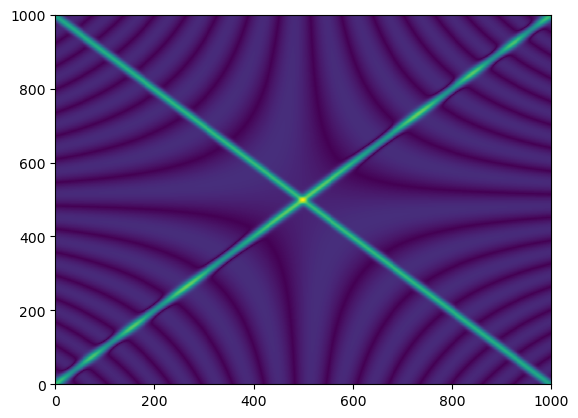

In [171]:
plt.pcolor(np.abs(test6))

In [162]:
A = np.exp(test6)/np.sqrt(1000)

In [169]:
np.linalg.matrix_rank(A)

159

In [367]:
np.linalg.inv(np.exp(test1))

array([[ 1.06612311e+14-4.76967381e+13j,  4.41954839e+13+6.06266001e+13j,
        -3.52089994e+13-6.09239575e+13j, ...,
        -2.48656171e+13+3.01191152e+13j, -3.79905634e+13-3.34589822e+13j,
         7.97661633e+13-5.58734525e+13j],
       [-6.96674653e+13+1.04702441e+14j, -9.81191126e+13-8.19968743e+12j,
         5.08884919e+13+8.93842384e+12j, ...,
        -4.61255468e+12-4.47629791e+13j,  6.90725181e+13+7.31038745e+12j,
        -4.19406431e+13+1.27831059e+14j],
       [-5.53159994e+13-7.74205262e+13j,  1.57952469e+13-5.04517944e+13j,
        -3.31668201e+13+7.09875934e+13j, ...,
         3.45083405e+13+7.04090511e+12j, -2.91952149e+13+1.93597902e+13j,
        -2.28942305e+13-4.29747893e+13j],
       ...,
       [-1.29997773e+13+3.31490585e+12j, -2.45475788e+12-1.24929084e+13j,
         4.92854420e+12+6.89000822e+12j, ...,
         5.10865711e+12-2.52796940e+12j,  1.72454041e+12+6.24693364e+12j,
        -1.24146242e+13+2.85442802e+12j],
       [ 4.48997061e+12-1.93484912e+12j,  2.

In [374]:
H = SHO_hamiltonian(x)
vals, vecs = np.linalg.eigh(H)

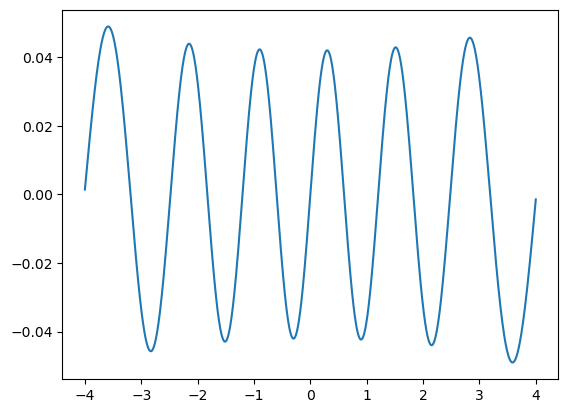

In [430]:
plt.plot(x,vecs[:,11])

In [278]:
np.dot(vecs[:,0], H @ vecs[:,0])

0.4999944406770941

In [292]:
DAT = discrete_angle_transform(vecs)

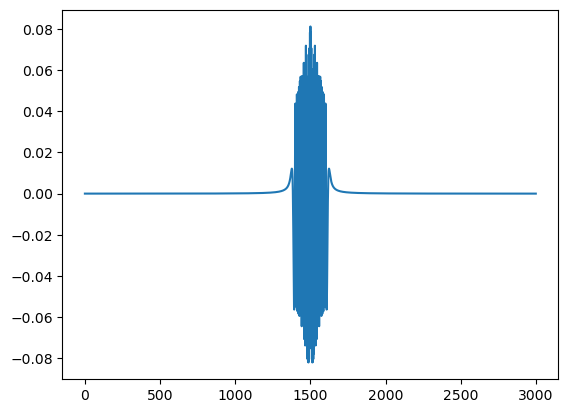

In [314]:
plt.plot(DAT[:,2900])

In [293]:
angle_gaussian = np.dot(DAT,real_gaussian)
angle_cosine = np.dot(DAT, a_cosine)

In [200]:
maybe_gausian = np.dot(np.conj(DAT.T), angle_gaussian)

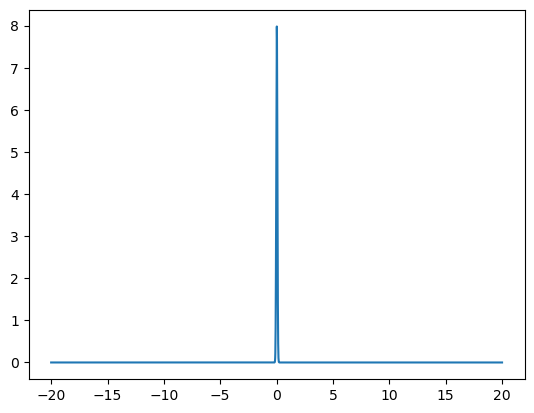

In [302]:
plt.plot(x, real_gaussian)

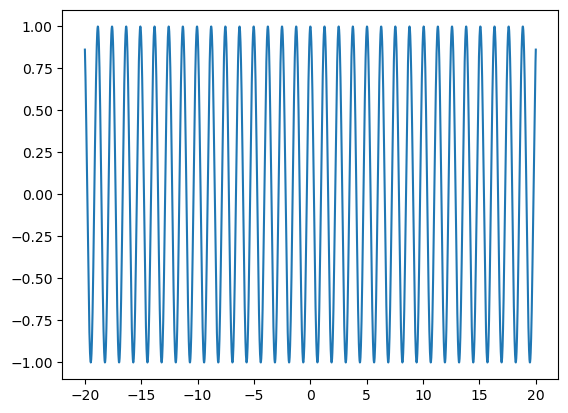

In [297]:
plt.plot(x,a_cosine)

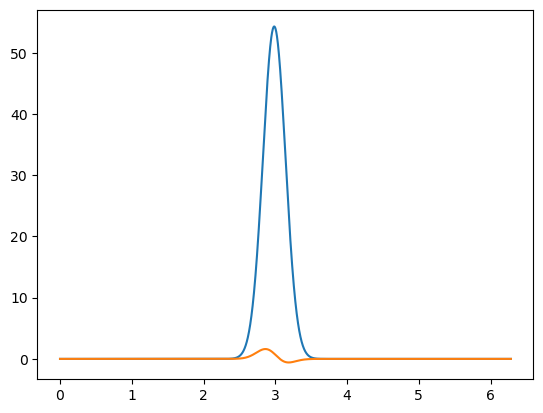

In [305]:
plt.plot(theta, np.real(angle_gaussian))
plt.plot(theta, np.imag(angle_gaussian))

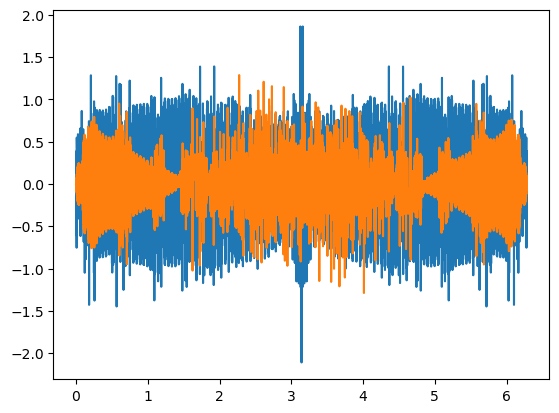

In [296]:
plt.plot(theta, np.real(angle_cosine))
plt.plot(theta, np.imag(angle_cosine))

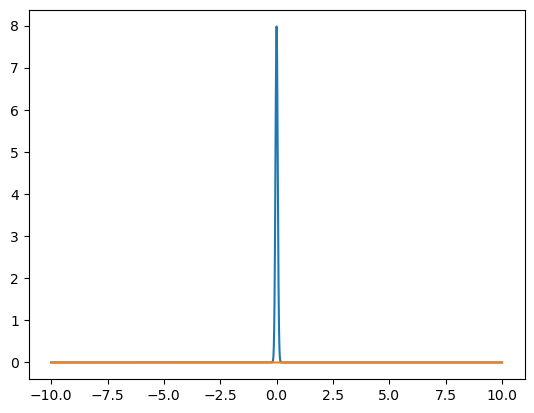

In [181]:
plt.plot(x, np.real(maybe_gausian))
plt.plot(x, np.imag(maybe_gausian))